In [2]:
!pip install sklearn --no-cache-dir --force-reinstall
!pip install gensim==4.0.*
!pip install mowl-borg

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gensim
  Running setup.py clean for gensim
Failed to build gensim
ERROR: Could not build wheels for gensim, which is require

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/mowl-tutorial/mowl")

Mounted at /content/drive


# Syntactic embeddings of ontologies

Syntactic embeddings embedding uses the syntax of axioms to generate sentences out of them. mOWL provides methods to generate text sentences from the axioms and/or the annotations in the ontology. The syntax chosen to generate the sentences is [Manchester Syntax](https://www.w3.org/2007/OWL/draft/ED-owl2-manchester-syntax-20081128/).

In [3]:
import mowl
mowl.init_jvm("10g")

We import our `Family Ontology` and the method `extract_axiom_corpus`, which extracts the axioms from the ontology and generates sentences in *Manchester Syntax*.

In [4]:
from mowl.corpus import extract_axiom_corpus
from mowl.datasets import PathDataset
dataset = PathDataset("data/family.owl")
corpus = extract_axiom_corpus(dataset.ontology)
len(corpus)

INFO:pykeen.utils:Using opt_einsum


FileNotFoundError: Training ontology file not found data/family.owl

Let's see the corpus generated:

In [ ]:
for s in corpus[:10]:
    print(s)

http://Father SubClassOf http://Male
http://Female SubClassOf http://Person
http://Female DisjointWith http://Male
http://Female EquivalentTo not http://Male
http://Female DisjointWith http://Male
http://Male SubClassOf http://Person
http://Mother SubClassOf http://Female
http://Parent SubClassOf http://Person
http://Parent SubClassOf http://hasChild some http://Person
http://Person EquivalentTo http://Female or http://Male


Now it is possible to input this corpus in a model like Word2Vec, which will generate numerical representations for our vocabulary. We will use the `gensim` library to do this.

In [ ]:
from gensim.models import Word2Vec

sentences = [s.split(" ") for s in corpus]
w2v = Word2Vec(sentences, epochs=200, vector_size = 50, min_count = 0)

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Finally, we can provide a visual representation of the entities. We will use a modified version of TSNE, which is implemented in mOWL:

In [ ]:
from mowl.visualization import TSNE as MTSNE

vectors = w2v.wv
vocab_dict = vectors.key_to_index
name_to_label = {c: c.split("/")[-1] for c in vocab_dict if str(c).startswith("http://")}
name_to_emb = {c: vectors[[c]][0] for c in name_to_label}

tsne = TSNE(name_to_emb, name_to_label)
tsne.generate_points(500, workers=4)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


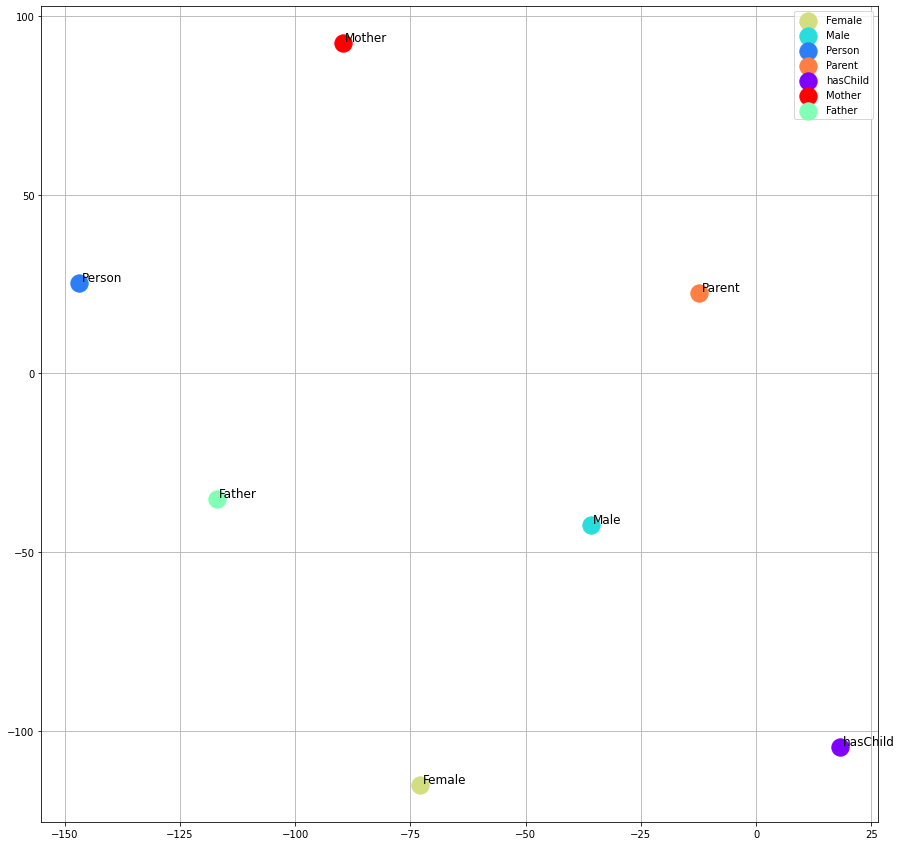

In [ ]:
tsne.show(thickness=300)

## Data augmentation via reasoning

We can generate more axioms by performing reasoning over the current ontology. mOWL provides access to ELK and Hermit reasoners. Those reasoners can be accessed using the OWLAPI directly or using the `MOWLReasoner` wrapper class that provides some shortcuts to reasoner methods.

In [ ]:
from mowl.reasoning.base import MOWLReasoner
from org.semanticweb.HermiT import Reasoner

reasoner = Reasoner.ReasonerFactory().createReasoner(dataset.ontology)
reasoner.precomputeInferences()

mowl_reasoner = MOWLReasoner(reasoner)
classes_to_infer_over = list(dataset.ontology.getClassesInSignature())

subclass_axioms = mowl_reasoner.infer_subclass_axioms(classes_to_infer_over)
equivalence_axioms = mowl_reasoner.infer_equivalent_class_axioms(classes_to_infer_over)
disjointness_axioms = mowl_reasoner.infer_disjoint_class_axioms(classes_to_infer_over)

Once the axioms were generated, it is time to add them to the ontology:

In [ ]:
from mowl.owlapi import OWLAPIAdapter

manager = OWLAPIAdapter().owl_manager

for ax in subclass_axioms:
    manager.addAxiom(dataset.ontology, ax)
for ax in equivalence_axioms:
    manager.addAxiom(dataset.ontology, ax)
for ax in disjointness_axioms:
    manager.addAxiom(dataset.ontology, ax)

Then we can do the embedding process with the updated ontology:

In [ ]:
corpus = extract_axiom_corpus(dataset.ontology)
print(f"The inferred ontology contains {len(corpus)} axioms")

The inferred ontology contains 44 axioms


In [ ]:
sentences = [str(s).split(" ") for s in corpus]
sentences = [[w.replace(",", "") for w in s] for s in sentences]
w2v = Word2Vec(sentences, epochs=200, vector_size = 50, min_count = 0)

vectors = w2v.wv
vocab_dict = vectors.key_to_index
name_to_label = {c: c.split("/")[-1] for c in vocab_dict if str(c).startswith("http://")}
name_to_emb = {c: vectors[[c]][0] for c in name_to_label}

tsne = TSNE(name_to_emb, name_to_label)
tsne.generate_points(500, workers=4)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


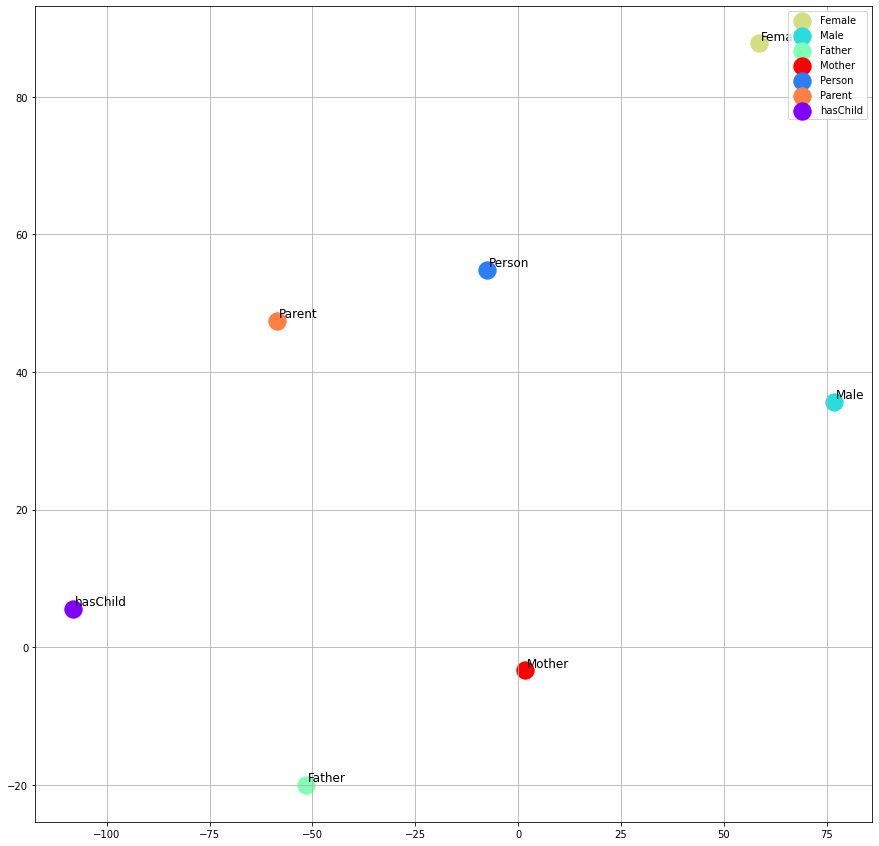

In [ ]:
tsne.show(thickness=300)

## Auxiliary TSNE function

In [ ]:
from mowl.visualization import TSNE as MTSNE
from sklearn.manifold import TSNE as SKTSNE
import numpy as np
import matplotlib.pyplot as plt

class TSNE(MTSNE):

    def __init__(self, *args, perplexity=5, thickness = 50,  **kwargs):
        super().__init__(*args, **kwargs)

        self.perplexity = perplexity
        self.thickness = thickness

    def generate_points(self, epochs, workers=1, verbose=0):
        """This method will call the :meth:`sklearn.manifold.TSNE.fit_transform`
        method to generate the points for the plot.

        :param epochs: Number of epochs to run the TSNE algorithm
        :type epochs: int
        :param workers: Number of workers to use for parallel processing. Defaults to 1.
        :type workers: int, optional
        :param verbose: Verbosity level. Defaults to 0.
        """
        points = np.array(list(self.embeddings.values()))
        if np.iscomplexobj(points):
            if verbose:
                warnings.warn("Complex numpy array detected. Only real part will be considered",
                              UserWarning)
            points = points.real
        self.points = SKTSNE(n_components=2, verbose=verbose, n_iter=epochs, n_jobs=workers, perplexity=self.perplexity)
        self.points = self.points.fit_transform(points)
        self.plot_data = {}

        for name, idx in self.embedding_idx_dict.items():
            label = self.labels[name]
            x, y = tuple(self.points[idx])

            if label not in self.plot_data:
                self.plot_data[label] = [], []
            self.plot_data[label][0].append(x)
            self.plot_data[label][1].append(y)

    def show(self, thickness = None):
        """ This method will call the :meth:`matplotlib.pyplot.show` method to show the plot.
        """
        if thickness is None:
            thickness = self.thickness

        fig, ax = plt.subplots(figsize=(15, 15))

        for label, (xs, ys) in self.plot_data.items():
            color = self.class_color_dict[label]
            ax.scatter(xs, ys, color=color, label=label, s=thickness)
            ax.text(xs[0]+0.5, ys[0]+0.5, label, fontsize=12)

            ax.legend()
            ax.grid(True)

        plt.show()